Using device: mps
Training Vanilla VAE...
====> Epoch: 1 Average Train Loss: 291.8396
====> Epoch: 1 Average Validation Loss: 265.6635
====> Test set loss: 266.7886
====> Epoch: 2 Average Train Loss: 259.6048
====> Epoch: 2 Average Validation Loss: 255.7878
====> Test set loss: 257.0508
====> Epoch: 3 Average Train Loss: 252.9213
====> Epoch: 3 Average Validation Loss: 251.5246
====> Test set loss: 252.7581
====> Epoch: 4 Average Train Loss: 249.6211
====> Epoch: 4 Average Validation Loss: 248.9891
====> Test set loss: 250.3005
====> Epoch: 5 Average Train Loss: 247.6328
====> Epoch: 5 Average Validation Loss: 247.3765
====> Test set loss: 248.6282
====> Epoch: 6 Average Train Loss: 246.3673
====> Epoch: 6 Average Validation Loss: 246.3450
====> Test set loss: 247.6032
====> Epoch: 7 Average Train Loss: 245.4486
====> Epoch: 7 Average Validation Loss: 245.5237
====> Test set loss: 246.8754
====> Epoch: 8 Average Train Loss: 244.7379
====> Epoch: 8 Average Validation Loss: 245.0977
====

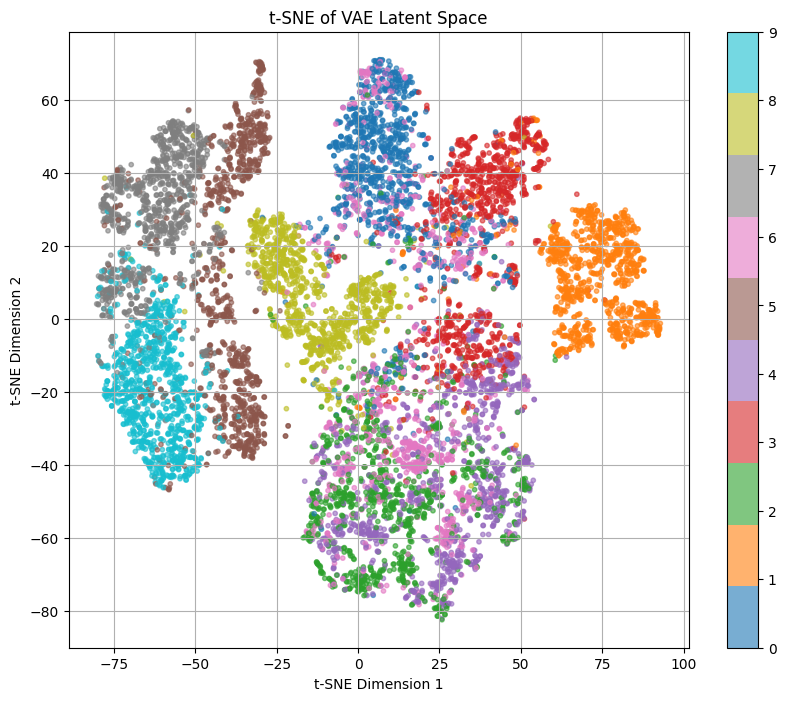

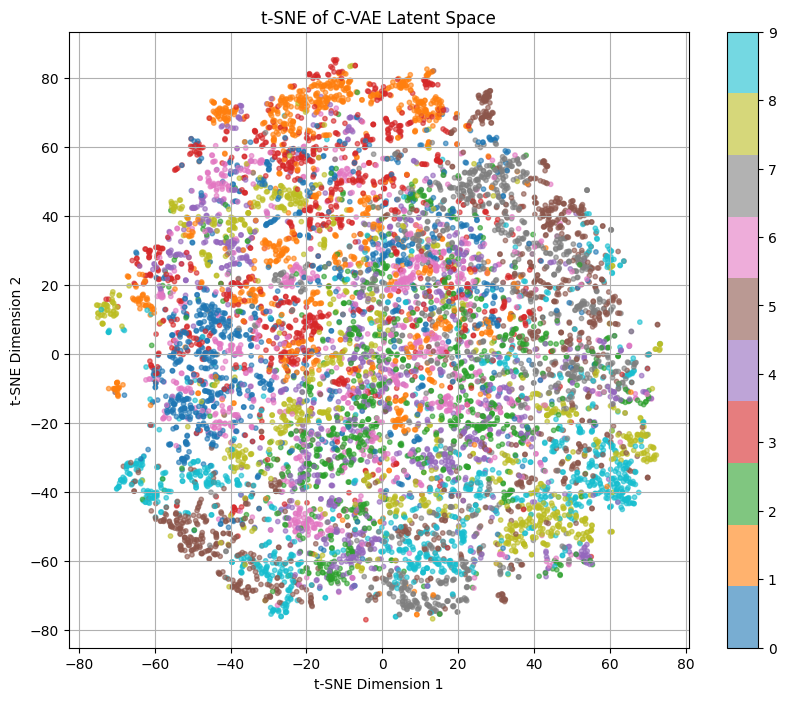

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import os

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f'Using device: {device}')

# Hyperparameters
n_in = 784  # 28x28 images
n_hid = 400
z_dim = 20
learning_rate = 1e-3
batch_size = 128
num_epochs = 25
validation_split = 0.2  # 20% for validation

# Create directory to save models
os.makedirs('models', exist_ok=True)

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Load Fashion MNIST dataset
train_val_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_set = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Split training data into training and validation sets
num_train = int((1 - validation_split) * len(train_val_set))
num_val = len(train_val_set) - num_train
train_set, val_set = random_split(train_val_set, [num_train, num_val])

# Data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Function to convert labels to one-hot encoding
def one_hot(labels, num_classes=10):
    return F.one_hot(labels, num_classes=num_classes).float()

# ---------------------------
# 3.1 Vanilla VAE Implementation
# ---------------------------
class VAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(n_in, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)  # For mean
        self.fc22 = nn.Linear(n_hid, z_dim)  # For log variance

        # Decoder layers
        self.fc3 = nn.Linear(z_dim, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x):
        """Encoder forward pass."""
        h = F.relu(self.fc1(x))
        mu = self.fc21(h)
        logvar = self.fc22(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Implements: z = mu + epsilon * std"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        """Decoder forward pass."""
        h = F.relu(self.fc3(z))
        recon_x = torch.sigmoid(self.fc4(h))
        return recon_x

    def forward(self, x):
        """Forward pass through the network."""
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Initialize VAE model
vae = VAE(n_in=n_in, n_hid=n_hid, z_dim=z_dim).to(device)
optimizer_vae = Adam(vae.parameters(), lr=learning_rate)

# Loss function: ELBO (Reconstruction loss + KL Divergence)
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')  # Reconstruction loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return BCE + KLD

# Training function for VAE
def train_vae(model, optimizer, train_loader, val_loader, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.view(-1, n_in).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} Average Train Loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, _ in val_loader:
            data = data.view(-1, n_in).to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f'====> Epoch: {epoch} Average Validation Loss: {avg_val_loss:.4f}')

# Testing function for VAE
def test_vae(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, n_in).to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f'====> Test set loss: {avg_test_loss:.4f}')
    return avg_test_loss

# Training loop for VAE
print("Training Vanilla VAE...")
for epoch in range(1, num_epochs + 1):
    train_vae(vae, optimizer_vae, train_loader, val_loader, epoch)
    test_loss = test_vae(vae, test_loader)

# Save the trained VAE model
torch.save(vae.state_dict(), 'models/vae_fashion_mnist.pth')
print("VAE model saved to 'models/vae_fashion_mnist.pth'")

# ---------------------------
# 3.2 Conditional VAE (C-VAE) Implementation
# ---------------------------
class CVAE(nn.Module):
    def __init__(self, n_in, n_hid, z_dim, n_classes=10):
        super(CVAE, self).__init__()
        self.n_classes = n_classes

        # Encoder layers
        self.fc1 = nn.Linear(n_in + n_classes, n_hid)
        self.fc21 = nn.Linear(n_hid, z_dim)  # For mean
        self.fc22 = nn.Linear(n_hid, z_dim)  # For log variance

        # Decoder layers
        self.fc3 = nn.Linear(z_dim + n_classes, n_hid)
        self.fc4 = nn.Linear(n_hid, n_in)

    def encode(self, x, c):
        """Encoder forward pass with conditioning."""
        x = torch.cat([x, c], dim=1)  # Concatenate input with one-hot class vector
        h = F.relu(self.fc1(x))
        mu = self.fc21(h)
        logvar = self.fc22(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """Implements: z = mu + epsilon * std"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        """Decoder forward pass with conditioning."""
        z = torch.cat([z, c], dim=1)  # Concatenate latent vector with one-hot class vector
        h = F.relu(self.fc3(z))
        recon_x = torch.sigmoid(self.fc4(h))
        return recon_x

    def forward(self, x, c):
        """Forward pass through the network with conditioning."""
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z, c)
        return recon_x, mu, logvar

# Initialize C-VAE model
cvae = CVAE(n_in=n_in, n_hid=n_hid, z_dim=z_dim).to(device)
optimizer_cvae = Adam(cvae.parameters(), lr=learning_rate)

# Training function for C-VAE
def train_cvae(model, optimizer, train_loader, val_loader, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.view(-1, n_in).to(device)
        labels = labels.to(device)
        c = one_hot(labels, num_classes=10).to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, c)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_train_loss = train_loss / len(train_loader.dataset)
    print(f'====> Epoch: {epoch} C-VAE Average Train Loss: {avg_train_loss:.4f}')

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, labels in val_loader:
            data = data.view(-1, n_in).to(device)
            labels = labels.to(device)
            c = one_hot(labels, num_classes=10).to(device)
            recon_batch, mu, logvar = model(data, c)
            loss = loss_function(recon_batch, data, mu, logvar)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f'====> Epoch: {epoch} C-VAE Average Validation Loss: {avg_val_loss:.4f}')

# Testing function for C-VAE
def test_cvae(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.view(-1, n_in).to(device)
            labels = labels.to(device)
            c = one_hot(labels, num_classes=10).to(device)
            recon_batch, mu, logvar = model(data, c)
            loss = loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f'====> C-VAE Test set loss: {avg_test_loss:.4f}')
    return avg_test_loss

# Training loop for C-VAE
print("\nTraining Conditional VAE (C-VAE)...")
for epoch in range(1, num_epochs + 1):
    train_cvae(cvae, optimizer_cvae, train_loader, val_loader, epoch)
    test_loss = test_cvae(cvae, test_loader)

# Save the trained C-VAE model
torch.save(cvae.state_dict(), 'models/cvae_fashion_mnist.pth')
print("C-VAE model saved to 'models/cvae_fashion_mnist.pth'")

# ---------------------------
# 3.3 Manifold Comparison using t-SNE
# ---------------------------

def extract_mu(model, data_loader, conditional=False):
    """Extracts the mean vectors from the encoder."""
    model.eval()
    mus = []
    labels_list = []
    with torch.no_grad():
        for data, labels in data_loader:
            data = data.view(-1, n_in).to(device)
            labels = labels.to(device)
            if conditional:
                c = one_hot(labels, num_classes=10).to(device)
                mu, _ = model.encode(data, c)
            else:
                mu, _ = model.encode(data)
            mus.append(mu.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    mus = np.concatenate(mus, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return mus, labels

# Extract mu vectors from test set for VAE
print("\nExtracting latent representations for VAE...")
mu_vae, labels_vae = extract_mu(vae, test_loader, conditional=False)

# Extract mu vectors from test set for C-VAE
print("Extracting latent representations for C-VAE...")
mu_cvae, labels_cvae = extract_mu(cvae, test_loader, conditional=True)

# Apply t-SNE to reduce dimensions to 2D
print("Applying t-SNE on VAE latent representations...")
tsne_vae = TSNE(n_components=2, random_state=42)
mu_vae_2d = tsne_vae.fit_transform(mu_vae)

print("Applying t-SNE on C-VAE latent representations...")
tsne_cvae = TSNE(n_components=2, random_state=42)
mu_cvae_2d = tsne_cvae.fit_transform(mu_cvae)

# Function to plot t-SNE results
def plot_tsne(mu_2d, labels, title):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mu_2d[:, 0], mu_2d[:, 1], c=labels, cmap='tab10', alpha=0.6, s=10)
    plt.colorbar(scatter, ticks=range(10))
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True)
    plt.show()

# Plot t-SNE for VAE
plot_tsne(mu_vae_2d, labels_vae, 't-SNE of VAE Latent Space')

# Plot t-SNE for C-VAE
plot_tsne(mu_cvae_2d, labels_cvae, 't-SNE of C-VAE Latent Space')


# Analysis

The t-SNE visualization of the VAE's latent space shows moderate clustering, with distinct regions for some classes but overlapping regions for others. This behavior aligns with expectations, as the VAE optimizes the evidence lower bound (ELBO) to balance reconstruction accuracy with the Kullback-Leibler (KL) divergence, which regularizes the latent space to resemble a standard Gaussian prior. Without explicit class supervision, the latent space reflects general structural organization of the data but lacks distinct class separability. 

Interestingly, while the t-SNE visualization of the C-VAE latent space suggests a more uniform distribution without clear clustering by class, additional experiments with class-conditioned image generation show that the C-VAE can effectively generate images corresponding to specific classes, such as shoes or shirts. This indicates that the C-VAE has learned meaningful class-specific representations despite the lack of visible separation in the t-SNE plot. I hypothesize that this discrepancy arises because the C-VAE has encoded class information in a way that is not globally separable but locally meaningful for decoding.

In other words, the C-VAE's latent space may lack clear, distinct boundaries between classes when viewed as a whole, but it encodes class-specific features in localized regions that the decoder can interpret effectively. This suggests that the encoder may map latent representations for different classes into overlapping high-dimensional spaces while still preserving sufficient structure for the decoder to generate class-conditional outputs. The t-SNE projection, which reduces high-dimensional data into two dimensions, might obscure these subtle yet meaningful distinctions by focusing on global patterns rather than localized relationships. 

It would be intresting to investigage this further perhaps with more dimensioanlity visualizaitons like UMAP or Rudi's PaCMAP. Additionally, increasing the latent dimension (`z_dim`) or adjusting the KL divergence weighting could allow for more explicit class separability while maintaining regularization. This behavior highlights the nuanced balance in C-VAEs between enforcing a Gaussian prior and encoding sufficient variability to represent class-specific features.

below you can see me generating some images for fun - but they were helpful in formulating this hypothesis too



Visualizing Reconstructed Images for VAE...


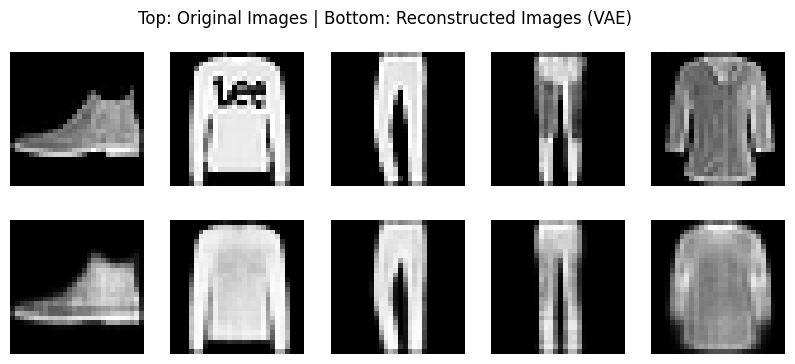

In [10]:
def visualize_reconstructions_vae(model, data_loader, num_images=10):
    """Visualizes original and reconstructed images for VAE."""
    model.eval()
    with torch.no_grad():
        data, _ = next(iter(data_loader))
        data = data.view(-1, n_in).to(device)
        recon, _, _ = model(data)
        recon = recon.view(-1, 1, 28, 28).cpu()
        data = data.view(-1, 1, 28, 28).cpu()
        
        fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            # Reconstructed images
            axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')
        plt.suptitle('Top: Original Images | Bottom: Reconstructed Images (VAE)')
        plt.show()

# After training the VAE, visualize the reconstructions
print("\nVisualizing Reconstructed Images for VAE...")
visualize_reconstructions_vae(vae, test_loader, num_images=5)

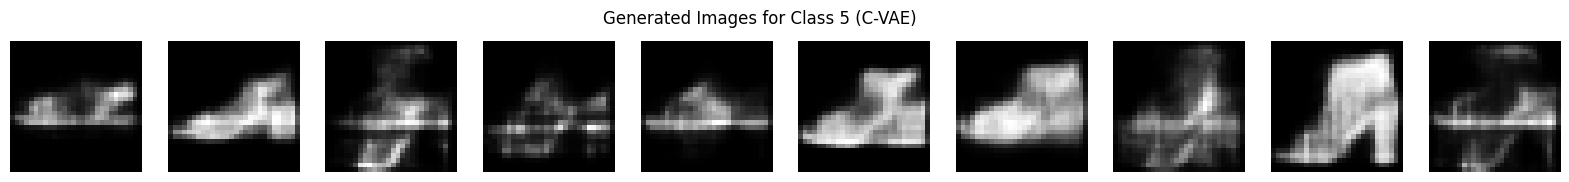

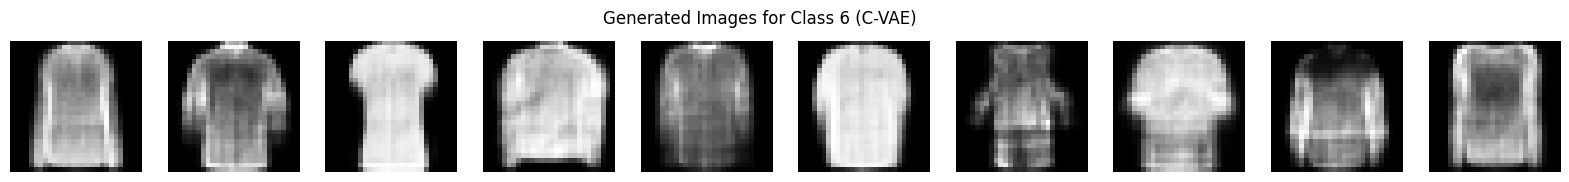

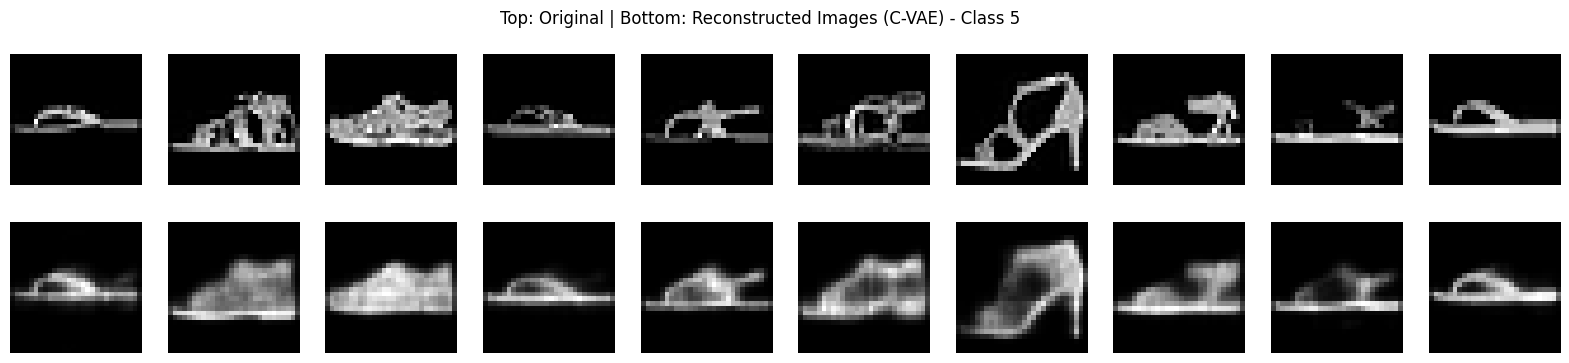

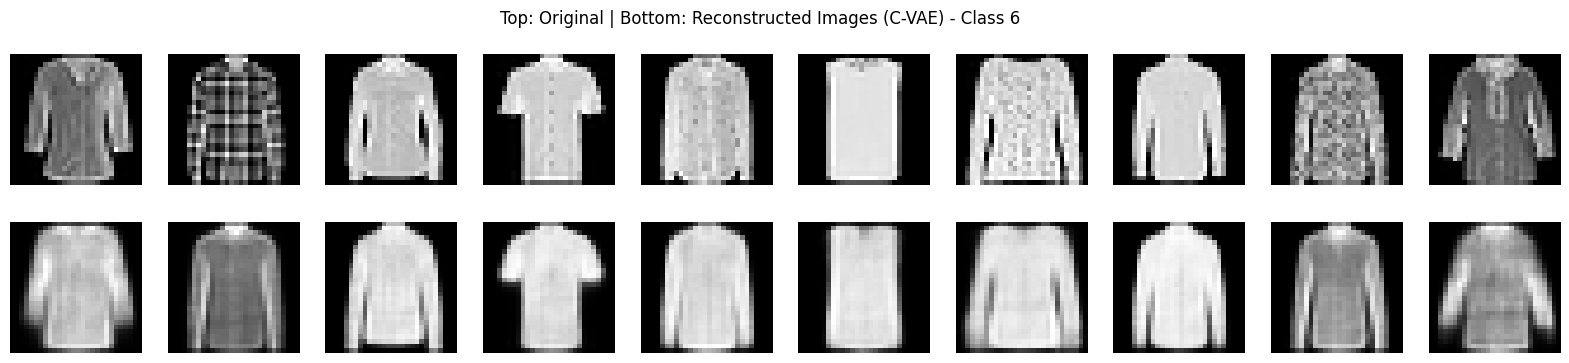

In [8]:
def generate_images_cvae(model, class_label, num_images=10):
    """Generates and visualizes images for a specific class using the CVAE."""
    model.eval()
    with torch.no_grad():
        # Create one-hot encoding for the specified class
        c = torch.zeros(num_images, 10).to(device)
        c[:, class_label] = 1
        
        # Sample z from standard normal distribution
        z = torch.randn(num_images, z_dim).to(device)
        
        # Generate images
        generated = model.decode(z, c).cpu()
        generated = generated.view(-1, 1, 28, 28)
        
        # Plot the generated images
        fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
        for i in range(num_images):
            axes[i].imshow(generated[i].squeeze(), cmap='gray')
            axes[i].axis('off')
        plt.suptitle(f'Generated Images for Class {class_label} (C-VAE)')
        plt.show()

# Example usage: Generate and visualize 10 images for class 5
generate_images_cvae(cvae, class_label=5, num_images=10)

# Example usage: Generate and visualize 10 images for class 6
generate_images_cvae(cvae, class_label=6, num_images=10)

def visualize_reconstructions_cvae(model, data_loader, class_label, num_images=10):
    """Visualizes original and reconstructed images for a specific class using CVAE."""
    model.eval()
    with torch.no_grad():
        # Filter data for the specified class
        for data, labels in data_loader:
            mask = labels == class_label
            data = data[mask]
            if len(data) >= num_images:
                data = data[:num_images]
                break
        
        data = data.view(-1, n_in).to(device)
        c = one_hot(torch.tensor([class_label]*num_images), num_classes=10).to(device)
        recon, _, _ = model(data, c)
        recon = recon.view(-1, 1, 28, 28).cpu()
        data = data.view(-1, 1, 28, 28).cpu()
        
        fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
        for i in range(num_images):
            # Original images
            axes[0, i].imshow(data[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            # Reconstructed images
            axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')
        plt.suptitle(f'Top: Original | Bottom: Reconstructed Images (C-VAE) - Class {class_label}')
        plt.show()

# Example usage: Visualize reconstructions for class 6
visualize_reconstructions_cvae(cvae, test_loader, class_label=5, num_images=10)

# Example usage: Visualize reconstructions for class 5
visualize_reconstructions_cvae(cvae, test_loader, class_label=6, num_images=10)